# MONAI/JADE Day Group Activity
Eric Kerfoot, KCL, 2024

## Preface: Resources:

* Website: https://monai.io
* Docs: https://docs.monai.io/en/stable/
  * API Ref: https://docs.monai.io/en/stable/api.html
  * Bundles: https://docs.monai.io/en/stable/bundle_intro.html
* Github: https://github.com/Project-MONAI/MONAI

## Introduction

Before starting:
* Ensure you can log into JADE through ssh or whatever other program you use.
* Follow instructions in lecture notes for setting up Miniconda or getting the Apptainer image.
* Ensure your Miniconda environment is setup with MONAI.

In this activity we are going to take a basic script for training an autoencoder and apply optimisations for running on JADE provided by MONAI. In the second part we will use MONAI's engine classes to implement the same code in more object-oriented and concise way with workflow classes, which can then be used as the basis for a bundle definition. 

We will need to download the Brain Tumour task from the Medical Segmentation Decathlon dataset: http://medicaldecathlon.com/ (for data details see https://arxiv.org/abs/1902.09063) This will take a bit of time so start now:

In [ ]:
!wget https://msd-for-monai.s3-us-west-2.amazonaws.com/Task01_BrainTumour.tar

Our task is to train an autoencoder to infer the gadolinium-enhanced T1w brain image from FLAIR, T1w and T2w images. This illustrates the use of large datasets and the considerations we have to make to optimally train with it, but it's not necessarily useful as a task. The code given here will train an `AutoEncoder` instance which accepts a three-channel volumetic input and produces a single-channel output representing synthetic GE image. An example of the outputs is given here:

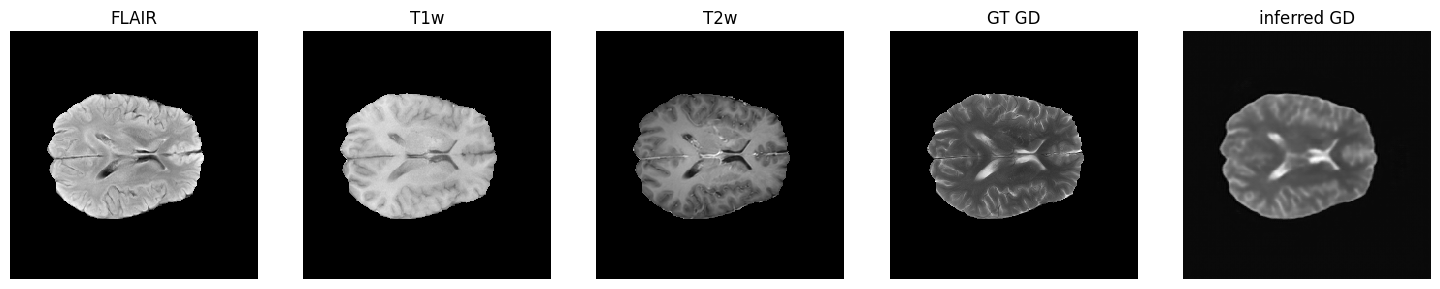

The following will write out the script file, you can run this cell or copy-paste everything after `%%writefile` to `brats_autoencoder.py`:

In [ ]:
%%writefile brats_autoencoder.py

import os
from glob import glob
from datetime import datetime
import torch
from monai.metrics import PSNRMetric
from monai.networks.nets import AutoEncoder
from monai.config import print_config
from monai.data import Dataset, DataLoader, partition_dataset
from monai.utils import set_determinism
from monai.transforms import (
    Compose,
    LoadImage,
    ScaleIntensityd,
    Lambda,
    SpatialPadd,
)

torch.multiprocessing.set_sharing_strategy('file_system')
print_config()
set_determinism(0)

# generate synthetic gadolinium-enhanced T1w brain image from FLAIR, T1w and T2w images.

device = "cuda:0" if torch.cuda.is_available() else "cpu"

root_dir = os.environ["TEMPSTORE"]

all_images = sorted(glob(f"{root_dir}/Task01_BrainTumour/images*/*.nii*"))
train_images, eval_images = partition_dataset(all_images, (4, 1), shuffle=True,seed=42)

IN_KEY = "in_images"
OUT_KEY = "ge_image"
keys = (IN_KEY, OUT_KEY)
pad_size = (256, 256, 160)

max_epochs = 60
batch_size = 10
num_workers = 10
learning_rate = 1e-3
valid_interval = 1


def _rearrange_images(img):
    img = img.permute(3, 0, 1, 2)
    return {IN_KEY: img[:3], OUT_KEY: img[3:]}
    

train_transforms = Compose([
    LoadImage(),
    Lambda(_rearrange_images),
    ScaleIntensityd(keys,channel_wise=True),
    SpatialPadd(keys, spatial_size=pad_size)
])

val_transforms = Compose([
    LoadImage(),
    Lambda(_rearrange_images),
    ScaleIntensityd(keys,channel_wise=True),
    SpatialPadd(keys, spatial_size=pad_size)
])

train_ds = Dataset(train_images, train_transforms,num_workers=4)
train_dl = DataLoader(train_ds, num_workers=num_workers, batch_size=batch_size, shuffle=True)
val_ds = Dataset(eval_images, val_transforms,num_workers=4)
val_dl = DataLoader(val_ds, num_workers=num_workers, batch_size=batch_size, shuffle=True)

model = AutoEncoder(
    spatial_dims=3,
    in_channels=3,
    out_channels=1,
    num_res_units=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2, 2),
).to(device)

# Create loss fn and optimiser
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
metric = PSNRMetric(1)
epoch_losses = []

for epoch in range(1, 1 + max_epochs):
    model.train()
    epoch_loss = 0
    step = 0
    for batch in train_dl:
        step += 1
        inputs, outputs_gt = batch[IN_KEY].to(device), batch[OUT_KEY].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, outputs_gt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_losses.append(epoch_loss)

    print(datetime.now().strftime(f"%H:%M:%S Epoch {epoch}, loss: {epoch_loss}"))
    
    if epoch % valid_interval == 0:  # validation
        valid_values = []
        model.eval()
        for batch in val_dl:
            inputs, outputs_gt = batch[IN_KEY].to(device), batch[OUT_KEY].to(device)
            outputs = model(inputs)
            valid_values.append(metric(outputs, outputs_gt))

        mval = torch.cat(valid_values).mean().item()
        print(datetime.now().strftime(f"%H:%M:%S Epoch {epoch}, mean validation: {mval}"))

torch.save(model.cpu().state_dict(), "ge_autoencoder.pt")

This is the script to run with SLURM, again you can run the cell or copy-paste:

In [ ]:
%%writefile brats_autoencoder.sh

#! /bin/bash
#SBATCH --nodes=1
#SBATCH -J brats_autoencoder
#SBATCH -c 8
#SBATCH --gres=gpu:1
#SBATCH --time=1:00:00
#SBATCH -p small

export TEMPSTORE="/raid/local_scratch/$USER/$SLURM_JOBID"
cd "$TEMPSTORE"
tar xf $HOME/Task01_BrainTumour.tar # assumes everything is in your home directory
cd $HOME  

$HOME/miniconda3/envs/monai/bin/python brats_autoencoder.py

## Objectives 
The important things we want to explore in this exercise:

* Setting up your environment to run MONAI, with Anaconda or Apptainer
* Improving the runtime performance of this script using MONAI components
* Add random augmentations which add diversity to the data but do not add too much runtime cost, and figuring out how to optimally apply these
* Further things unrelated to JADE can be explored, such as a better network definition, better loss or validation metric, data preprocessing, etc.

Optional objectives we can look at together if time permits (there's a lot to cover):

* Converting the script to use Ignite-based workflow classes
* Packaging things into a bundle
* Experiment with multi-GPU training

## First Thing: Setup

Ensure you can run MONAI through either Anaconda or the Apptainer image. As discussed in the README.md to get the pre-made Apptainer package:

```bash
wget https://emckclac-my.sharepoint.com/:u:/g/personal/k1077505_kcl_ac_uk/EVKPVgenB0xDof_PmufBBT0B1yzpz528PYLJx0H6uC5OBQ?download=1 -O monai.sif
```

If you're using Anaconda, try running the above bash script with `sbatch brats_autoencoder.sh`. We have a reservation for this event so you can add the `--reservation=KCL_MONAI` flag to the command to use our allocated pool of GPUs. If you want to use the Apptainer image refer to the notes on how to modify this script to do that.

If you want to interact with the running script or experiment on the command line, an interactive job makes sense which you can launch with:

```bash
srun -p devel -c 8 --gres=gpu:1 --pty --reservation=KCL_MONAI /bin/bash
```

Within this running job you can invoke the script with `bash brats_autoencoder.sh`. Be aware this will extract the tar file each time.

It's going to be slow so pre-trained weights are provided if you want to see what the output looks like and start from that state when training. The .py file specifies 20 epochs of training which the run script probably hasn't allocated enough time for. To get an idea of what runtime is going to be like you should run the script once with epochs set to 2. This will be the baseline for the rest of this notebook you can compare against as we try to optimise training.

## Faster Dataset Types

MONAI provides dataset types which use caching strategies to improve speed. These trade memory for load time which can make a big difference if you don't run out of RAM. A few of these are:

* [CacheDataset](https://docs.monai.io/en/stable/data.html#cachedataset): This will load everything into memory when constructed.
* [PersistentDataset](https://docs.monai.io/en/stable/data.html#persistentdataset): Uses the file system to cache transformed data so that preprocessing operations are done only the once.
* [SmartCacheDataset](https://docs.monai.io/en/stable/data.html#smartcachedataset): Uses a smarter hybrid algorithm to use both memory and storage, however it requires more careful use as shown in the documentation.

You should substitute the main dataset class for one of these to try and speed up training performance. The other dataset for validation may not benefit from this but it's up to you to experiment. Things to consider here include how many CPU cores you're going to request and where persistent data may live. This assumes you're using a single node and single GPU, but if you used multiples of each you would have to consider other implications as well.

## Transforms

Transforms are key components of MONAI in that they represent the process for pre-processing, augmenting, and post-processing data. These are organised into deterministic ones for loading data, adding channels, applying fixed crops or pads, etc., and those for applying randomised augmentations to data for regularisation. [A list of transforms by category can be found here](https://docs.monai.io/en/stable/transforms_idx.html).

The two types of transforms are those for operating on individual arrays or tensors ("Array transforms"), and those for operating on dictionaries of the same ("Dictionary transforms" which have a "d" suffix). Below is an example of random augmentations using array transforms:

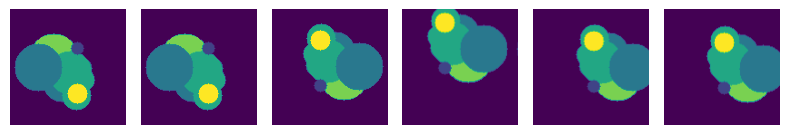

In [26]:
import matplotlib.pyplot as plt
from monai.data.synthetic import create_test_image_2d
from monai.transforms import Compose, EnsureChannelFirst, RandAffine, RandFlip

im, seg = create_test_image_2d(128, 128)

trans = Compose([
    EnsureChannelFirst(channel_dim="no_channel"),
    RandAffine(prob=0.5, translate_range=(20, 20)),
    RandFlip(prob=0.5)
])

imgs = [im[None, ...]] + [trans(im) for _ in range(5)]

fig, axs = plt.subplots(1, len(imgs), figsize=(8, 4), layout="tight")
for idx, ax in enumerate(axs):
    ax.imshow(imgs[idx][0])
    ax.axis("off")

The purpose of dictionary transforms is to apply operations to two or more arrays/tensors simultaneously, such as to an image with it's segmentation:

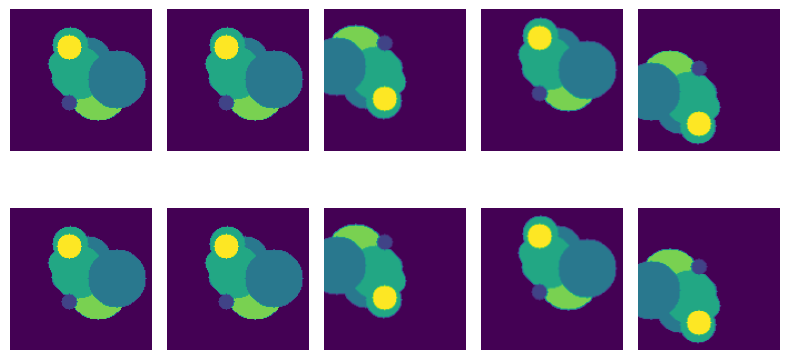

In [28]:
from monai.transforms import EnsureChannelFirstd, RandAffined, RandFlipd
from monai.utils import CommonKeys

keys = (CommonKeys.IMAGE, CommonKeys.LABEL)

trans = Compose([
    EnsureChannelFirstd(keys, channel_dim="no_channel"),
    RandAffined(keys, prob=0.5, translate_range=(20, 20)),
    RandFlipd(keys, prob=0.5),
])

dict_obj = {CommonKeys.IMAGE: im, CommonKeys.LABEL: seg}

imgs = [trans(dict_obj) for _ in range(5)]

fig, axs = plt.subplots(2, len(imgs), figsize=(8, 6), layout="tight")

for idx, (ax0, ax1) in enumerate(zip(*axs)):
    ax0.imshow(imgs[idx][CommonKeys.IMAGE][0])
    ax0.axis("off")
    ax1.imshow(imgs[idx][CommonKeys.LABEL][0])
    ax1.axis("off")

These don't look terribly different but take my word for it that this works.

In the script that you were given, there's a mix of array and dictionary transforms. This is because the function `_rearrange_images` was used in a `Lambda` transforms to produce a dictionary output from a single array, namely it split the GE image from the other 3. `Lambda/Lambdad` is a convenience transform for injecting your own code in the pipeline. The `SpatialPadd` is present because the autoencoder network will downsample the inputs a certain number of times, and so the dimensions have to be divisible by 16. It's possible to use other transforms which padd or crop to a divible factor which may be more appropriate.

The script doesn't use any augmentation transforms for data regularisation, so experiment with adding these in now. How this impacts runtime performance and results is important to consider. The caching transforms will only cache the first series of deterministic transforms (those without `Rand` in the name) so consider the ordering of those as well. Common transforms used for augmentation:

* `RandAffined`
* `Rand3DElasticd`
* `RandFlipd` and related `RandAxisFlipd`
* Various versions of random cropping
* `RandGaussianNoise` and other forms of noise
* `RandShiftIntensity`

## Distributed Data Parallel

The script as given uses only a single GPU. What we want is a program that can be scaled to multiple GPUs using Distributed Data Parallel (DDP). This will allow data to be divided amongst multiple processes which train on separate GPUs and coordinate network weights. The things that need to be modified in the script:

* Initialise and destroy the distributed process group
* Define per-process `device` objects
* Define distributed samplers for the data loaders
* Wrap the network with DistributedDataParallel
* Run training with `torchrun`, eg.
  
  `$HOME/miniconda3/envs/monai/bin/torchrun --nnodes=1 --nproc_per_node=2  brats_autoencoder_ddp.py`


DDP tutorial: https://pytorch.org/tutorials/intermediate/ddp_tutorial.html

For bundles, an extra config file can be used as a mixin to add these components: https://github.com/Project-MONAI/model-zoo/blob/dev/models/segmentation_template/configs/multi_gpu_train.yaml


## Workflows

In this part you can rewrite the script to use our workflow classes. This is optional but is instructive for how many MONAI programs, and specifically bundles, are structured.

Workflow classes in MONAI inherit from those in Ignite (https://github.com/pytorch/ignite). These are used to wrap the training components and algorithms in classes for reusability and flexibility. Many features are provided with these such as automatic data handling, AMP implementation, and various events to hook your code into and customise training without defining your own types.

One good example in the Tutorials repo: https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/challenge_baseline/run_net.py

A critical definition is the training class:

```python
train_handlers = [
    ValidationHandler(validator=evaluator, interval=1, epoch_level=True),
    StatsHandler(tag_name="train_loss", output_transform=from_engine(["loss"], first=True)),
]
trainer = monai.engines.SupervisedTrainer(
    device=device,
    max_epochs=max_epochs,
    train_data_loader=train_loader,
    network=net,
    optimizer=opt,
    loss_function=DiceCELoss(),
    inferer=get_inferer(),
    key_train_metric=None,
    train_handlers=train_handlers,
    amp=amp,
)
```

This defines what device is used, number of epochs, data loader, network, whether to use AMP, etc. It also is provided with two handler objects which trigger evaluation and the end of each epoch, and log statistic information. The `evaluator` object is defined as:

```python
val_post_transform = monai.transforms.Compose(
    [AsDiscreted(keys=("pred", "label"), argmax=(True, False), to_onehot=2)]
)
val_handlers = [
    ProgressBar(),
    CheckpointSaver(save_dir=model_folder, save_dict={"net": net}, save_key_metric=True, key_metric_n_saved=3),
]
evaluator = monai.engines.SupervisedEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=net,
    inferer=get_inferer(),
    postprocessing=val_post_transform,
    key_val_metric={
        "val_mean_dice": MeanDice(include_background=False, output_transform=from_engine(["pred", "label"]))
    },
    val_handlers=val_handlers,
    amp=amp,
)
```

This demonstrates a class for running inference only on a network and using metric types to evaluate performance. Coupling this object to the trainer object using a `ValidationHandler` keeps the two concerns separate. The evaluator definition ca be used for an inference script as well to generate results using a trained network.

Handlers are triggered at different times during training based off of events such as the end of an iteration or epoch. Further information on Ignite concepts is here: https://pytorch-ignite.ai/concepts/ 


### Bundle

If you have your code re-implemented as workflow classes the conversion to a bundle is much simpler. The suggestion here is to start with the [segmentation template](https://github.com/Project-MONAI/model-zoo/tree/dev/models/segmentation_template) and adapt it to our network here. The major changes for this bundle are:

* Using our network instead of the UNet
* Different data loading
* Different loss function and metrics

Much of the rest of the script files makes sense for this straight-forward supervised training scheme. The key concept behind how the bundle scripts work is that they define Python objects, so building a script is the process of constructing a tree of object instantiations. For example, the Python code line `demo_net = monai.networks.nets.BasicUNet(spatial_dims=3, in_channels=1, out_channels=2,features= [16, 16, 32, 32, 64, 64])` would be represented in JSON as:

```json
{
  "demo_net": {
    "_target_": "monai.networks.nets.BasicUNet",
    "spatial_dims": 3,
    "in_channels": 1,
    "out_channels": 2,
    "features": [16, 16, 32, 32, 64, 64]
  }
}
```

In the segmentation template training script, the top-level object is the trainer workflow class, defined (in YAML which has an equivalent JSON form):

```yaml
trainer:
  _target_: SupervisedTrainer
  max_epochs: '@num_epochs'
  device: '@device'
  train_data_loader: '@train_dataloader'
  network: '@network'
  inferer: '@inferer'  # unnecessary since SimpleInferer is the default if this isn't provided
  loss_function: '@lossfn'
  optimizer: '@optimizer'
  # postprocessing: '@postprocessing'  # uncomment if you have train metrics that need post-processing
  key_train_metric: null
  train_handlers: '@handlers'
```

This refers to other object definitions with the `@` syntax. The [bundle documentation](https://docs.monai.io/en/stable/bundle_intro.html) details the otehr special symbols used in the JSON/YAML script files. With a bit of time it becomes clear how to convert Python code into a JSON/YAML object definition of this form.

## The End

Hopefully this workshop has been instructive for applying MONAI to HPC environments like JADE. This notebook lists far more things than can be done in the day but it illustrates a number of important concepts. Please refer to the provided links in the notes and especially https://docs.monai.io/en/stable/ for further documentation on what MONAI provides and how it works.